# Introduction

This notebook shows how to create a neural network to detect momo in images using Inception V3

# Imports

In [1]:
import numpy as np
import tensorflow as tf
import datetime; 
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
from time import time

from shutil import copy2, rmtree, copytree
from tqdm import tqdm
from sys import stdout
from os import listdir, makedirs, remove
from os.path import isfile, join, isdir, exists, dirname, abspath
from inspect import getsourcefile
from tensorflow import keras
from numpy.random import seed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Downloading dataset from Github

In [2]:
![ ! -d "dataset" ] && echo "Cloning dataset project from github" && git clone https://github.com/alphonse92/momo-dataset.git ./dataset 
!cd dataset       && git reset --hard && git pull && git checkout V2

Cloning dataset project from github
Cloning into './dataset'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1432 (delta 0), reused 4 (delta 0), pack-reused 1427
Receiving objects: 100% (1432/1432), 219.09 MiB | 12.44 MiB/s, done.
Resolving deltas: 100% (15/15), done.
HEAD is now at 7e7bb4a remove ds store
Already up to date.
Checking out files: 100% (1461/1461), done.
Branch 'V2' set up to track remote branch 'V2' from 'origin'.
Switched to a new branch 'V2'


In [3]:
# Load Inception V3.

InceptionV3             = keras.applications.inception_v3.InceptionV3
     
preprocess_input        = keras.applications.inception_v3.preprocess_input
image                   = keras.preprocessing.image
     
ImageDataGenerator      = keras.preprocessing.image.ImageDataGenerator
Callback                = keras.callbacks
     
Model                   = keras.models.Model
Sequential              = keras.models.Sequential
layers                  = keras.layers
     
Input                   = layers.Input
Dense                   = layers.Dense
Conv2D                  = layers.Conv2D
ZeroPadding2D           = layers.ZeroPadding2D
BatchNormalization      = layers.BatchNormalization
AveragePooling2D        = layers.AveragePooling2D
MaxPooling2D            = layers.MaxPooling2D
GlobalAveragePooling2D  = layers.GlobalAveragePooling2D
Dropout                 = layers.Dropout



# Notebook Configuration 


In [4]:
# Notebook Configuration
USE_INCEPTION_V3_MODEL = True
RESET_TRAINING_EXAMPLES = True
SAVE_WEIGHTS = True
SEED_APP = 9

# DATASET PROPORTIONS
TRAINING_PERCENTAGE = 0.7
TESTING_PERCENTAGE  = 0.15
EVAL_PERCENTAGE     = 0.15

# HYPERPARAMETERS
CRITERIA_THRESHOLD = 0.7
EPOCHS = 30
BATCH_SIZE = 15
IMG_W = IMG_H = 299

# MODEL CHECKPOINTS CONFIGURATION
SAVE_CHECKPOINTS = 2
SAVE_WEIGHTS_FREQUENCY = 'epoch'
SAVE_WEIGTHS_PERIOD = EPOCHS // SAVE_CHECKPOINTS

# COLAB SCOPE
MOUNT_G_DRIVE = False
GOOGLE_COLLAB = False                                                            # Default value. You should not modify this
GOOGLE_RESET_CONTENT_TREE = True                                                 # Reset the dataset content tree. It means remove and re copy the data from drive
MOUNT = "./"                                                                     # Base path of this project. You may not change this value   
G_MOUNT = "/content/drive"                                                       # Set where the drive folder will be mounted
G_PROJECT_PATH = G_MOUNT+ "/My Drive/Colab Notebooks/uruit-ml-momo-test/"        # Set the pathe where momo project is 

# If colab instance, then build the content tree
try:
  import google.colab
  from google.colab import drive
  if MOUNT_G_DRIVE: 
    drive.mount('/content/drive', force_remount=GOOGLE_RESET_CONTENT_TREE)
  GOOGLE_COLLAB = True
except:
  GOOGLE_COLLAB = False
  print(tf.test.gpu_device_name())
  

# Variables

In [5]:
tf.random.set_seed(SEED_APP)

MOMO_CLASSNAME    = "momo"
NO_MOMO_CLASSNAME = "no_momo"

DATASET_PATH = join(MOUNT, "dataset/")
DATESET_BASIC_PATH    = join(DATASET_PATH,'basic/')
DATESET_TRAINING_PATH = join(DATASET_PATH,'train/')
DATESET_TESTING_PATH  = join(DATASET_PATH,'test/')
DATESET_EVAL_PATH     = join(DATASET_PATH,'eval/')

RESULT_FOLDER_PATH = join(MOUNT,"result/")
VISUALIZATION_FOLDER = RESULT_FOLDER_PATH + "basic-predictions/"
VISUALIZATION_LATEST_RESULT_FOLDER = "latest/"

INCEPTION_V3_MODEL_NAME = "inception_v3"
RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH = RESULT_FOLDER_PATH + INCEPTION_V3_MODEL_NAME + "/"
DEFAULT_WEIGHTS_FILE_NAME = 'weights.h5'
DEFAULT_WEIGHTS_FILE_PATH = RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + DEFAULT_WEIGHTS_FILE_NAME

performanceDF = pd.DataFrame()

print(DATESET_BASIC_PATH)

./dataset/basic/


# Functions

In [6]:
def getDistribuitions(array,TRAINING_PERCENTAGE,TESTING_PERCENTAGE,EVAL_PERCENTAGE):
  m         = len(array)
  trainIdx  = math.ceil( m * TRAINING_PERCENTAGE )
  testIdx   = math.ceil( m * TESTING_PERCENTAGE  ) 
  evalIdx   = math.ceil( m * EVAL_PERCENTAGE     )     

  np.random.seed(SEED_APP)
  np.random.shuffle(array)

  currentIndex     = 0
  trainingImages   = array[ currentIndex : currentIndex + trainIdx ]

  currentIndex     = currentIndex + trainIdx 
  testImages       = array[ currentIndex : currentIndex + testIdx  ]

  currentIndex     = currentIndex + testIdx
  evalImages       = array[ currentIndex :          ]

  return {
      'train':trainingImages,
      'test' :testImages,
      'eval' :evalImages
  }

def getFolders(path):
    return [d for d in listdir(path) if isdir(join(path, d))]

def getFolderFiles(path: str):
    return [f for f in listdir(path) if isfile(join(path, f))]  


def predict(path, model) -> np.array:
    img = image.load_img(path, target_size=(299, 299))
    # Size  (299, 299, 3)
    imgArray = image.img_to_array(img) 
    
    # Size  (1, 299, 299, 3)
    expandedImgArray = np.expand_dims(imgArray, axis=0) 
    
    # Preproces to inceptionV3, normalize each pixel RGB value to an scale of zero to one
    processedImgArray = preprocess_input(expandedImgArray) 
    
    return model.predict(processedImgArray)

def getTimestamp():
    return datetime.datetime.now().timestamp()
    
def getRandomExample(xClass:str):
    np.random.seed(SEED_APP)
    exampleFileList = getFolderFiles(DATESET_BASIC_PATH + xClass)
    
    rndIndex = np.random.randint(0,len(exampleFileList))
    filename = exampleFileList[rndIndex]
    return join(DATESET_BASIC_PATH,xClass,filename)

def getDatasetClasses():
    return getFolders(DATESET_BASIC_PATH)

def getOutputClasses():
    return [NO_MOMO_CLASSNAME,MOMO_CLASSNAME]
    
def createFolderIfNotExist(folderPath):
    if not exists(folderPath):
        makedirs(folderPath)

def deleteIfExist(filepath):
    if exists(filepath):
        rmtree(filepath)
        
def resetFolderIfExist(path : str):
    deleteIfExist(path)
    createFolderIfNotExist(path)

def saveInFileIfNotExist(filepath: str, content: str):
  
    # Create (or not) the result folder
    createFolderIfNotExist(dirname(filepath))
    
    with open(filepath, mode="a") as f:
        f.write(content + '\n')
        

def plotModelTrainingProgress(progress):
  # Acc stats
  plt.plot(progress.history['accuracy'])
  plt.plot(progress.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Loss stats
  plt.plot(progress.history['loss'])
  plt.plot(progress.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
def createConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]                
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def getDataForConfusionMatrix(model):
    threshold = CRITERIA_THRESHOLD
    eval_Xs = []
    eval_Ys = []
    eval_preds = []
    files = []

    #folderPath = DATESET_TRAINING_PATH
    folderPath = DATESET_EVAL_PATH

    folders = getFolders(folderPath)

    for folder in folders:

        images                = getFolderFiles(folderPath+ folder)
        totalOfImagesInFolder = len(images)

        print("Processing" ,  folder , " total of images: ",totalOfImagesInFolder)

        for img in tqdm(images, file=stdout):
            src = folderPath + folder + "/" + img        
            files.append(src)
            result = predict(src,model)[0][0]

            # generamos una lista con las probabilidades devueltas por el modelo para cada imagen.
            eval_preds.append(result)

            # generamos nuestra lista de y_true, es decir la etiqueta de quebería tener la foto.
            eval_Xs.append(1 if folder == MOMO_CLASSNAME else 0)

            # generamos nuestra lista de y_pred, es decir la etiqueta que nos dio la predicción.
            eval_Ys.append(1 if result > threshold else 0)

    files      = np.array(files)
    eval_preds = np.array(eval_preds)
    eval_Xs    = np.array(eval_Xs)
    eval_Ys    = np.array(eval_Ys)
    
    momoModel.load_weights(DEFAULT_WEIGHTS_FILE_PATH)
    return (files,eval_preds,eval_Xs,eval_Ys)


def printConfussionMatrix(model):
  files,eval_preds,eval_Xs,eval_Ys = getDataForConfusionMatrix(model)
  createConfusionMatrix(
    eval_Xs,
    eval_Ys,
    title="Confusion matrix",
    classes=getOutputClasses(),
    normalize=True
)
        
def createInceptionModel():
  baseModel = InceptionV3(weights='imagenet', include_top=False, pooling=  'avg')
  baseModel.trainable = False
  
  # Take the output of the model
  x = baseModel.output

  # Add a full-conected layer of 1024 neurons with relu activation to our model output
  x = Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.6)(x)
  #x = Dense(512, activation='relu')(x)

  # Add a output layer with only one neurone
  momoOutput = Dense(1, activation='sigmoid')(x)

  # Create the momo Model from our outputs
  model = Model(inputs=baseModel.input, outputs=momoOutput)

  for layer in baseModel.layers:
    layer.trainable = False

  # Compile our model using adam and an optimizer for binari clasification
  model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

  return model


# Preparing InceptionV3 Model to fit it to our problem: identify momo in. images

In [7]:
momoModel = createInceptionModel()

87916544/87910968 [==============================] - 2s 0us/step


# Pre training

## Prepare our test/training folders

In [8]:
# Read each class of the dataset
for ds_class in getOutputClasses():
    # Create the folders in the train/test folders
    resetFolderIfExist( DATESET_TRAINING_PATH  +  ds_class  )
    resetFolderIfExist( DATESET_TESTING_PATH   +  ds_class  )
    resetFolderIfExist( DATESET_EVAL_PATH      +  ds_class  )


## Fill the train/test/eval folders

In [9]:
def CreateTrainTestAndEvalFolders():
    np.random.seed(SEED_APP)
    DATASET_CLASSES = getDatasetClasses()

    ds_folders = getFolders(DATESET_BASIC_PATH)

    for ds_folder in ds_folders:

        path      = DATESET_BASIC_PATH + ds_folder
        files     = np.array(getFolderFiles(path))


        distributions = getDistribuitions(files,
                          TRAINING_PERCENTAGE,
                          TESTING_PERCENTAGE,
                          EVAL_PERCENTAGE
        )

        trainingImages = distributions["train"]
        testImages     = distributions["test"]
        evalImages     = distributions["eval"]
        
        isPositiveClass      = ds_folder == MOMO_CLASSNAME
        folderTo             = MOMO_CLASSNAME if isPositiveClass else NO_MOMO_CLASSNAME

        trainingClassPath    = DATESET_TRAINING_PATH + folderTo
        testClassPath        = DATESET_TESTING_PATH  + folderTo
        evalClassPath        = DATESET_EVAL_PATH     + folderTo

        resetFolderIfExist(trainingClassPath)
        resetFolderIfExist(testClassPath)
        resetFolderIfExist(evalClassPath)


        print(
            "From folder '" + ds_folder  + "'"
            + " take " 
            + str(len(trainingImages)) + " Training examples, "
            + str(len(testImages))     + " Testing examples, and "
            + str(len(evalImages))     + " Eval examples."
            + "\n"        
        )

        print("Copying traning files from " + path + " to " + trainingClassPath)
        for imageName in tqdm(trainingImages, file=stdout):
            copy2(path+ "/"+  imageName ,trainingClassPath + "/"+  imageName)

        print("Copying testing files from " + path + " to " + testClassPath)
        for imageName in tqdm(testImages, file=stdout):
            copy2(path+ "/"+  imageName ,testClassPath + "/"+  imageName)

        print("Copying eval files from "    + path + " to " + evalClassPath)
        for imageName in tqdm(evalImages, file=stdout):
            copy2(path+ "/"+  imageName ,evalClassPath + "/"+  imageName)
        print()
        print()
            
CreateTrainTestAndEvalFolders()


From folder 'person' take 130 Training examples, 28 Testing examples, and 27 Eval examples.

Copying traning files from ./dataset/basic/person to ./dataset/train/no_momo
100%|██████████| 130/130 [00:00<00:00, 2554.18it/s]
Copying testing files from ./dataset/basic/person to ./dataset/test/no_momo
100%|██████████| 28/28 [00:00<00:00, 893.48it/s]
Copying eval files from ./dataset/basic/person to ./dataset/eval/no_momo
100%|██████████| 27/27 [00:00<00:00, 1197.85it/s]


From folder 'momo' take 304 Training examples, 66 Testing examples, and 64 Eval examples.

Copying traning files from ./dataset/basic/momo to ./dataset/train/momo
100%|██████████| 304/304 [00:00<00:00, 1692.91it/s]
Copying testing files from ./dataset/basic/momo to ./dataset/test/momo
100%|██████████| 66/66 [00:00<00:00, 2224.59it/s]
Copying eval files from ./dataset/basic/momo to ./dataset/eval/momo
100%|██████████| 64/64 [00:00<00:00, 2204.46it/s]


From folder 'meme' take 91 Training examples, 20 Testing examples, and 1


## Data augmentation

In [10]:
# Create a generator to pre process our dataset images
imageGenerator = ImageDataGenerator(
    rescale            = 1./255,       # Scale our data to our dataset scale
    horizontal_flip    = True,         # Horizontal mirror
    vertical_flip      = False,         # Disable vertical mirror
    rotation_range     = 7,
    width_shift_range  = 0.3,
    height_shift_range = 0.3,
    brightness_range   = (0.3, 0.7),
    shear_range        = 5.0,
    fill_mode          = "reflect"
)

trainGenerator = imageGenerator.flow_from_directory(
        directory   = DATESET_TRAINING_PATH,
        batch_size  =  BATCH_SIZE,
        class_mode  =  'binary',
        classes     =  getOutputClasses())

testGenerator= imageGenerator.flow_from_directory(
        directory    = DATESET_TESTING_PATH,

        batch_size   = BATCH_SIZE,
        class_mode   = 'binary',
        classes      = getOutputClasses())

Found 365 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [11]:
trainGenerator.class_indices

{'momo': 1, 'no_momo': 0}

# Training

Lets save some util data from our foulders

In [12]:
trainPositiveFiles          = getFolderFiles(DATESET_TRAINING_PATH + MOMO_CLASSNAME)
trainNegativeFiles          = getFolderFiles(DATESET_TRAINING_PATH + NO_MOMO_CLASSNAME)
trainPositiveExamplesLength = len(trainPositiveFiles)
trainNegativeExamplesLength = len(trainNegativeFiles)
trainLength                 = trainPositiveExamplesLength + trainNegativeExamplesLength

print("Total train examples: ", trainLength , "positive: " , trainPositiveExamplesLength  , " negative: " , trainNegativeExamplesLength)

testPositiveFiles           = getFolderFiles(DATESET_TESTING_PATH + MOMO_CLASSNAME)
testNegativeFiles           = getFolderFiles(DATESET_TESTING_PATH + NO_MOMO_CLASSNAME)
testPositiveExamplesLength  = len(testPositiveFiles)
testNegativeExamplesLength  = len(testNegativeFiles)
testLength                  = testPositiveExamplesLength + testNegativeExamplesLength

print("Total test examples: ", testLength , "positive: " , testPositiveExamplesLength  , " negative: " , testNegativeExamplesLength)
print()

trainSteps = trainLength // BATCH_SIZE
testSteps  = testLength // BATCH_SIZE

print("Train Steps per epoch " , trainSteps)
print("Test Steps per epoch " , testSteps)


resetFolderIfExist(RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH)


Total train examples:  365 positive:  304  negative:  61
Total test examples:  79 positive:  66  negative:  13

Train Steps per epoch  24
Test Steps per epoch  5


In [13]:
TRAINING_TIME_START = time()
progress = momoModel.fit_generator(
        trainGenerator,
        steps_per_epoch=trainSteps,
        epochs=EPOCHS,
        validation_data=testGenerator,
        validation_steps=testSteps
)
TRAINING_TIME_END = time()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
24/24 [==============================] - 15s 617ms/step - loss: 0.9254 - accuracy: 0.7857 - val_loss: 1.0321 - val_accuracy: 0.8267
Epoch 2/30
24/24 [==============================] - 13s 534ms/step - loss: 0.4237 - accuracy: 0.8714 - val_loss: 0.1590 - val_accuracy: 0.9600
Epoch 3/30
24/24 [==============================] - 13s 532ms/step - loss: 0.2291 - accuracy: 0.9229 - val_loss: 0.1348 - val_accuracy: 0.9733
Epoch 4/30
24/24 [==============================] - 13s 535ms/step - loss: 0.1448 - accuracy: 0.9486 - val_loss: 0.2895 - val_accuracy: 0.9200
Epoch 5/30
24/24 [==============================] - 13s 531ms/step - loss: 0.1853 - accuracy: 0.9400 - val_loss: 0.4779 - val_accuracy: 0.8800
Epoch 6/30
24/24 [==============================] - 13s 532ms/step - loss: 0.2527 - accuracy: 0.9229 - val_loss: 0.2305 - val_accuracy: 0.9200
Epoch 7/30
24/24 [==============================] - 13s 535ms/step

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


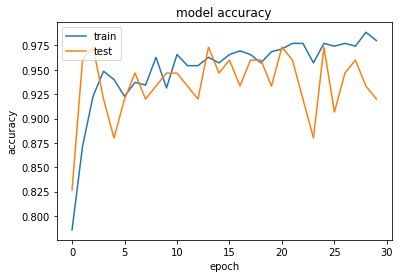

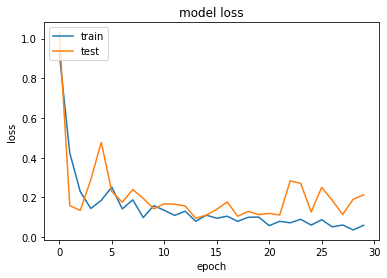

In [14]:
def saveInceptionV3CheckpointAndDraw():

  print(progress.history.keys())
  loss              = progress.history["loss"][-1]
  val_loss          = progress.history["val_loss"][-1]

  accuracy         = progress.history["accuracy"][-1]
  val_accuracy     = progress.history["val_accuracy"][-1]

  perfData = {
        'loss'         :  loss,             
        'val_loss'     :  val_loss,    
        'accuracy'     :  accuracy,    
        'val_accuracy' :  val_accuracy,
        'training_time':  (TRAINING_TIME_END - TRAINING_TIME_START),
        'train_length' :  trainLength,
        'test_length'  :  testLength
  }

  
  momoModel.save_weights( DEFAULT_WEIGHTS_FILE_PATH)
  plotModelTrainingProgress(progress)
  return perfData 

perfData = saveInceptionV3CheckpointAndDraw()
performanceDF = performanceDF.append(perfData, ignore_index=True)

Processing momo  total of images:  64
100%|██████████| 64/64 [00:07<00:00,  8.78it/s]
Processing no_momo  total of images:  12
100%|██████████| 12/12 [00:01<00:00, 11.88it/s]


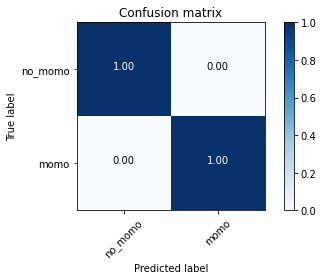

In [15]:
printConfussionMatrix(momoModel)

In [16]:
# View performance data
performanceDF.head()

,accuracy,loss,test_length,train_length,training_time,val_accuracy,val_loss
0,0.98,0.060213,79.0,365.0,412.838237,0.92,0.213608


In [17]:
momoModel.save('./model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/assets


In [18]:
!zip -r -9 dist.zip model 

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/saved_model.pb (deflated 93%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 79%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 7%)


In [19]:
if GOOGLE_COLLAB:
  from google.colab import files
  files.download("dist.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>